EXTRACTION OF NC FILE OF TOPOGRAPHY FROM HEROLD DATASET

In [1]:
import xarray as xr
import numpy as np

ds = xr.open_dataset("~/work/git/Herold_SRA/Plasim-LSG/herold_etal_stddev_subgrid_etopo1_to_eocene_1x1.nc" )

ds.variables.keys()
ds.var

<bound method DatasetAggregations.var of <xarray.Dataset>
Dimensions:                     (ncl0: 54, ncl1: 54, ncl2: 54, lat: 180,
                                 lon: 360)
Coordinates:
  * lat                         (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
  * lon                         (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
Dimensions without coordinates: ncl0, ncl1, ncl2
Data variables:
    stderror                    (ncl0) float32 ...
    mean_of_stddev              (ncl1) float32 ...
    mean_of_heights             (ncl2) float32 ...
    paleo_stddev_subgrid_topo   (lat, lon) float32 ...
    paleotopo                   (lat, lon) float32 ...
    etopo1                      (lat, lon) float32 ...
    etopo1_stddev_subgrid_topo  (lat, lon) float32 ...>

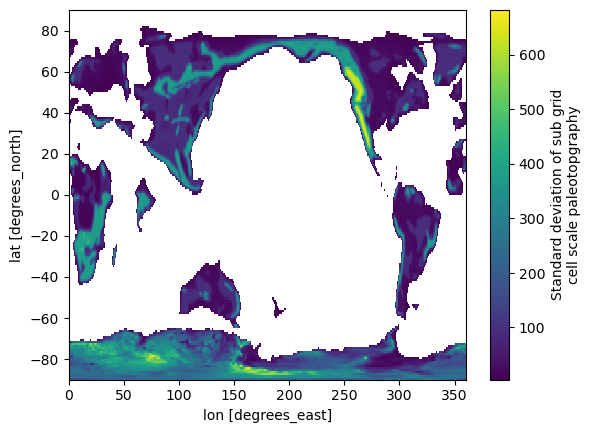

In [2]:
ds['paleo_stddev_subgrid_topo'].plot()

The file is with 1° x 1° resolution so it needs to be converted to PlaSIM view (5.6° x 5.6°) : rotation + transposition to have it centered in the pacific ocean with North Pole in the North and Africa and Europe on the right side.

CONVERSION INTO PLASIM GRID

In [3]:
topo_clean = ds['paleo_stddev_subgrid_topo'].fillna(0)  # Fill NaNs with 0 for interpolation

# 1. Define your new target grid
new_lat = np.arange(-85.76, 85.76, 5.53)
new_lon = np.arange(0.0, 354.4, 5.625)

# 2. Interpolate directly 
ds_interp = topo_clean.interp(lat=new_lat, lon=new_lon)
# 3. Save
ds_interp.to_netcdf('topo_final.nc')
print(ds_interp)

<xarray.DataArray 'paleo_stddev_subgrid_topo' (lat: 32, lon: 64)>
array([[         nan, 260.08975708, 256.45518745, ..., 218.89090313,
        229.03520126, 236.36608562],
       [         nan, 227.42753695, 247.89671196, ..., 163.10838055,
        178.51293209, 185.42774378],
       [         nan, 335.01364822, 324.64038086, ...,  49.25422134,
        197.45027313, 377.73705673],
       ...,
       [         nan,   5.71558652,   0.        , ...,  31.92810892,
         26.72430893,  20.62998934],
       [         nan,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [         nan,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
  * lat      (lat) float64 -85.76 -80.23 -74.7 -69.17 ... 74.61 80.14 85.67
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Attributes:
    long_name:  Standard deviation of sub grid cell scale paleotopgraphy


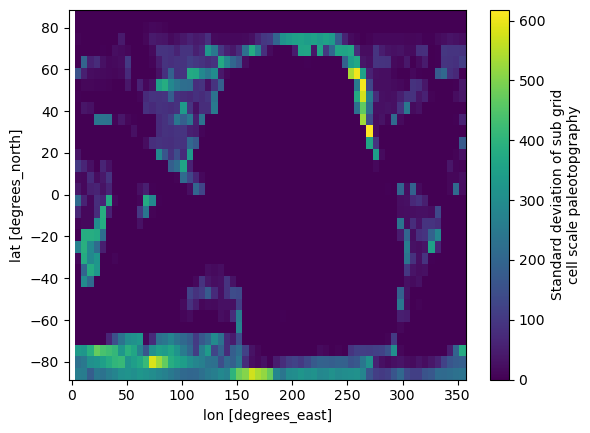

In [4]:
ds_interp.plot()

*CDO Remapping: Python Output to PlaSim Grid*

**Objective:** Adapt the topography file generated by Python (`topo_final.nc`) onto the coarse resolution Gaussian grid required by the PlaSim model (T21).

 1. *Target Grid Definition* (`grid_plasim.txt`)
First, the target Gaussian grid (64x32) is defined in a text file named `grid_plasim.txt` with the following parameters:

```text
gridtype  = gaussian
gridsize  = 2048
xsize     = 64
ysize     = 32
xname     = lon
xlongname = "longitude"
xunits    = "degrees_east"
yname     = lat
ylongname = "latitude"
yunits    = "degrees_north"
numLPE    = 16
xfirst    = 0
xinc      = 5.625

To perform the remapping, we use the following bash command. This takes the Python output, applies the target grid definition using Conservative Remapping (remapcon), and produces the final PlaSim-ready file:

cdo remapcon,grid_plasim.txt topo_final.nc topo_final_plasim.nc

-------------------------------------------------------------- 

The orography data required unit conversion, as the Herold dataset provides elevation in geometric meters ($m$), whereas PLaSim requires surface geopotential ($m^2/s^2$). Consequently, the elevation field $h$ was multiplied by the gravitational acceleration $g$ ($m/s^2$) to derive the surface geopotential.

### Surface Geopotential (Orography) (`0129.sra`)

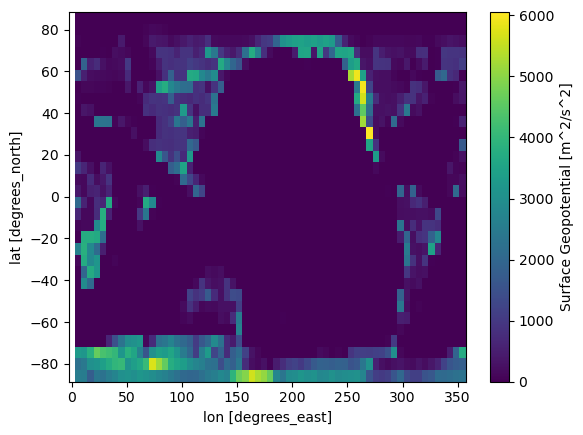

In [5]:
g = 9.80665
sg = ds_interp * g

ds_final = sg.to_dataset(name='sg')
ds_final['sg'].attrs = {'units': 'm^2/s^2', 'long_name': 'Surface Geopotential'}
ds_final.to_netcdf('0129.nc')
ds_final['sg'].plot()

Starting from the remapped topography file did with CDO procedure (topo_final_plasim.nc), we generated the final input file (0129_cdo.nc) entirely using CDO commands.

cdo -setattribute,sg@units="m^2/s^2",sg@long_name="Surface Geopotential" \
    -chname,paleo_stddev_subgrid_topo,sg \
    -mulc,9.80665 \
    topo_final_plasim.nc 0129_cdo.nc


To validate this file, we compared it against the topography generated via the Python procedure. We took the Python output (topo_final.nc), remapped it to the PlaSim grid, and performed a direct difference check against our CDO-generated file. 

cdo remapcon,grid_plasim.txt 0129.nc 0129_remapped.nc

cdo diffn 0129_remapped.nc 0129_cdo.nc

Warning : Diff : S Z  Max_Absdiff  Max_Reldiff : Parameter name
       F T  9.0949e-13   3.3899e-16  : sg


This value is negligible (effectively zero) and represents computational noise (floating-point rounding errors) caused by the different processing paths (Python vs CDO). Therefore, the two procedures are consistent, and the generated file 0129_cdo.nc is scientifically accurate and safe to use.

### LAND-SEA MASK (`0172.sra`)

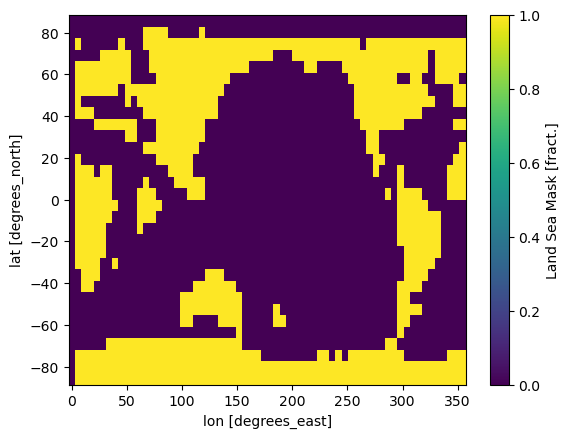

In [6]:

# Condition: If sg > 0 it is Land (1), else it is Sea (0)
# We use floating point numbers (1.0 and 0.0) because PLaSim expects fractions.
lsm = xr.where(ds_final['sg'] > 0, 1.0, 0.0)

ds_lsm = lsm.to_dataset(name='lsm')

ds_lsm['lsm'].attrs = {
    'units': 'fract.',  # Fraction (0 to 1)
    'long_name': 'Land Sea Mask',
    'standard_name': 'land_binary_mask'
}

ds_lsm.to_netcdf('0172.nc')

ds_lsm['lsm'].plot() 

This result would need to be therefore remapped on Plasim gaussian grid since it's currently on a simple lonlat grid.


To ensure physical consistency though between the topography and the land-sea mask, the Land Sea Mask (`lsm`) is derived directly from the final Surface Geopotential file (`0129_cdo.nc`), created with the CDO procedure.

**Logic:**
* If `sg > 0`: It is Land (1).
* If `sg <= 0`: It is Sea (0).

### CDO Command
We use a chained command to:
1.  **Create the Binary Mask:** `-gtc,0` sets values > 0 to 1, and others to 0.
2.  **Rename Variable:** Changes `sg` to `lsm`.
3.  **Set Metadata:** Assigns units (`fract.`) and long name.

```bash
cdo -setattribute,lsm@units="fract.",lsm@long_name="Land Sea Mask" \
    -chname,sg,lsm \
    -gtc,0 \
    0129_cdo.nc 0172_cdo.nc

#The final files are in work/git/ folder called 0129_cdo.nc 0172_cdo.nc 

-------------------------------------------------------------

### Roughness Length (`0173.sra`)

**Variable:** `z0` Roughness Length - meters ($m$)

The total roughness length ($z_0$) is calculated as the **Root Sum Square** of the vegetation roughness ($z_{veg}$) and the orographic roughness ($z_{topo}$), following the formulation used in the PLaSim `simba.f90` module.

$$z_0 = \sqrt{z_{veg}^2 + z_{topo}^2}$$

#### **1. Vegetation Roughness ($z_{veg}$)**
Derived from the **Herold et al. Eocene Biome** dataset (`eocene_biome_hp`).  Each grid cell was classified as either "Forest" or "Non-Forest" based on its biome ID and assigned a corresponding roughness value. 

$$z_{veg} = 2.0 \cdot I_{forest} + 0.05 \cdot (1 - I_{forest})$$

Where $I_{forest}$ is a binary flag (1 for Forest, 0 for Non-Forest) derived from the biome ID:

* **Forest ($I_{forest}=1$), ($z_{veg} = 2.0 \, m$):**

  * `1`: Tropical forest
  * `2`: Warm-temperate forest
  * `3`: Temperate forest
  * `4`: Boreal forest

* **Non-Forest / Bare Soil ($I_{forest}=0$), ($z_{veg} = 0.05 \, m$):**
  * `5`: Savanna and dry woodland
  * `6`: Grassland and dry shrubland
  * `7`: Desert

#### **2. Topographic Roughness ($z_{topo}$)**
Derived from the **Herold et al. Subgrid Topography** dataset (`paleo_stddev_subgrid_topo`).  
This represents the drag caused by sub-grid mountain features. It is estimated as 1% of the standard deviation of the sub-grid elevation ($\sigma_{z}$), with a safety cap at 100m.

$$z_{topo} = 0.01 \times \sigma_{z}$$

In [9]:
# ==========================================
# 1. VEGETATION ROUGHNESS (z_veg)
# ==========================================

# Load Biome Data

ds_bio = xr.open_dataset("~/work/git/Herold_SRA/Plasim-LSG"
"/herold_etal_eocene_biome_1x1.nc")
biome = ds_bio['eocene_biome_hp'] 

ds_bio['eocene_biome_hp'] = ds_bio['eocene_biome_hp'].fillna(0)

ds_bio.to_netcdf('biomes.nc')



*CDO Remap*

cdo remapnn,grid_plasim.txt biomes.nc biomes_cdo.nc

The "remapnn" of the nearest neighbour was used to preserve the file containing the integers with the different vegetation classes.

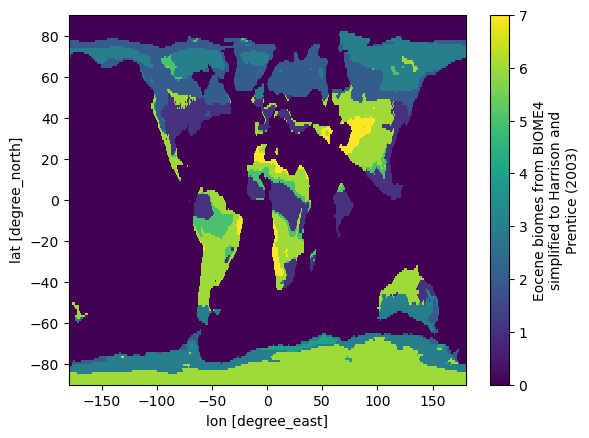

In [24]:
ds_bio['eocene_biome_hp'].plot()

In [11]:
ds_bio_remapped = xr.open_dataset('biomes_cdo.nc')

biome_cdo = ds_bio_remapped['eocene_biome_hp']

# Define Biome Classes (Forest vs Non-Forest)
# Forest Codes -> Roughness = 2.0 m

forest_codes = [
    1, # Tropical forest
    2, # Warm-temperate forest
    3, # Temperate forest
    4  # Boreal forest
]

# Non-Forest Codes -> Roughness = 0.05 m
non_forest_codes = [
    5, # Savanna and dry woodland
    6, # Grassland and dry shrubland
    7  # Desert
]

is_forest = biome_cdo.isin(forest_codes).astype(float) # 1.0 or 0.0

# Apply Roughness Values
forest_flag = is_forest
# Forest = 2.0m, Non-Forest = 0.05m

roughness_forest = 2.0
roughness_non_forest = 0.05

zveg = roughness_forest * forest_flag + roughness_non_forest * (1 - forest_flag)

# Regrid vegetation roughness to PLaSim resolution
# Important: We regrid the *roughness values*, not the biome IDs.
# This ensures that a cell with 50% forest and 50% grass gets an average roughness (~1.025m).


zveg.to_netcdf('zveg.nc')


We took the topo_final_plasim.nc file that has already been remapped to Plasim grid with CDO procedure (remapcon) at the beginning.

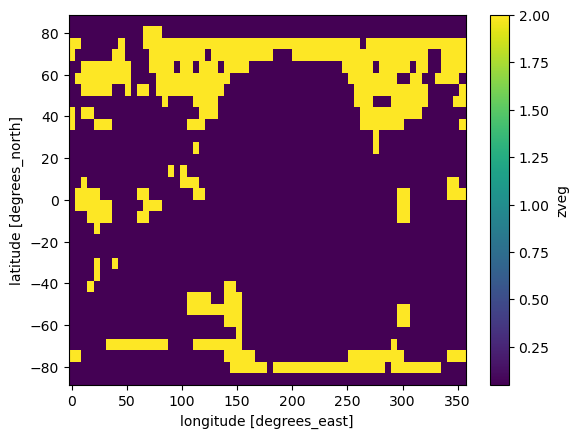

In [22]:
zveg.plot()

In [13]:


# ==========================================
# 2. TOPOGRAPHIC ROUGHNESS (z_topo)
# ==========================================

# Load Subgrid Standard Deviation
# Fill NaNs (Ocean) with 0 and Regrid

topo_remapped = xr.open_dataset('~/work/git/topo_final_plasim.nc')

# Calculate z_topo
# Roughness is approx 1% of the standard deviation of elevation

ztopo = topo_remapped * 0.01

# Clamp values to avoid numerical instability (max 100m)

ztopo = ztopo.clip(min=0.001, max=100.0)

ztopo.to_netcdf('ztopo.nc')


cdo setname,zveg zveg.nc zveg_fixed.nc

cdo setname,ztopo ztopo.nc ztopo_fixed.nc

mv zveg_fixed.nc zveg.nc

mv ztopo_fixed.nc ztopo.nc

Now the variables inside the nc files are called zveg and ztopo.

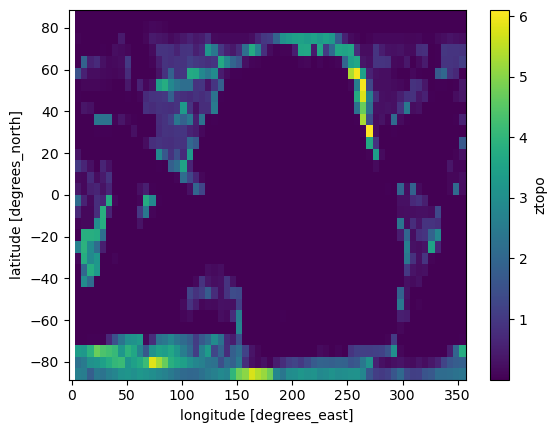

In [23]:
ztopo.plot()

In [18]:

# ==========================================
# 3. TOTAL ROUGHNESS (dz0)
# ==========================================
# Formula from simba.f90: dz0 = sqrt(zvz0^2 + dz0climo^2)

ds_zveg = xr.open_dataset('zveg.nc')
ds_ztopo = xr.open_dataset('ztopo.nc')

zveg = ds_zveg['zveg']   
ztopo = ds_ztopo['ztopo'] 

#Calculate the Total Roughness
# Formula: Square root of the sum of squares

total_roughness = np.sqrt(zveg**2 + ztopo**2)

ds_z0 = total_roughness.to_dataset(name='z0')

ds_z0['z0'].attrs = {
    'units': 'm',
    'long_name': 'Surface Roughness Length',
    'standard_name': 'surface_roughness_length',
    'code': 173,  # GRIB code that PLaSim looks for
    'source': 'Combined Herold Biome + Topo StdDev'
}

# Make sure there are no NaNs (the ocean must have a value or be handled)
# PLaSim accepts 0 over the ocean if there is a land-sea mask, 
# but a low value (e.g., 0.0001) is safer to avoid division by zero.

ds_z0['z0'] = ds_z0['z0'].fillna(0.0001)

ds_z0.to_netcdf('0173.nc')

print(f"Minimum Value: {ds_z0['z0'].min().values:.4f} m")
print(f"Maximum Value: {ds_z0['z0'].max().values:.4f} m")

Minimum Value: 0.0001 m
Maximum Value: 6.3349 m


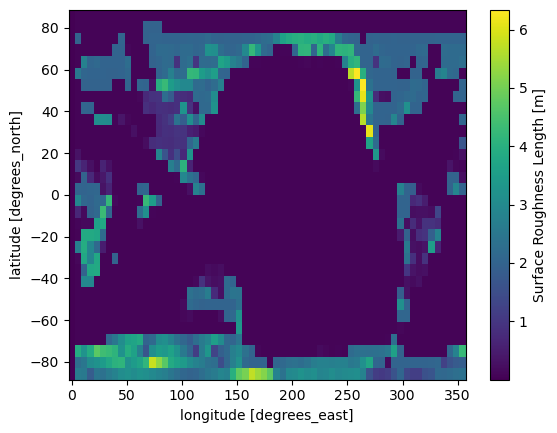

In [21]:
ds_z0['z0'].plot()

We renamed with cdo "ztopo.nc" into "1730.nc" and "zveg.nc" into "1731.nc", following the Plasim nomenclature, and moved them in the work/git folder.

### Forest Ratio (`0212.sra`)

This boundary condition file defines the forest coverage fraction for the PLaSim SRA module, derived from the Herold et al. Eocene biome reconstruction.

Grid cells classified as Tropical, Temperate, or Boreal forests (codes 1-4) are assigned a value of 1.0 (Forest), while Grasslands and Deserts (codes 5-7) are assigned 0.0 (Non-Forest).

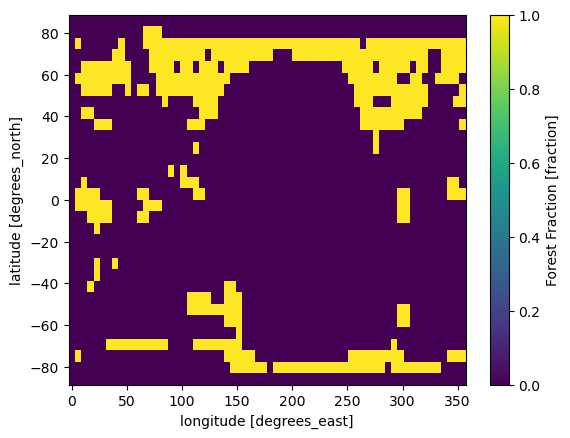

In [ ]:
ds_lsm = xr.open_dataset('~/work/git/0172_cdo.nc')
lsm = ds_lsm['lsm']  

ds_bio_remapped = xr.open_dataset('biomes_cdo.nc')
biome_cdo = ds_bio_remapped['eocene_biome_hp']

biome = biome_cdo.reindex_like(lsm, method='nearest')

forest_codes = [1, 2, 3, 4]      # Tropical, Warm-temp, Temperate, Boreal
non_forest_codes = [5, 6, 7]     # Savanna, Grassland, Desert

forest_ratio = xr.full_like(lsm, 0.0, dtype=float)

# Must be LAND (lsm >= 0.5) AND must be FOREST
# Note: lsm >= 0.5 handles both binary (0/1) and fractional masks

is_land = (lsm >= 0.5)
is_forest_biome = biome.isin(forest_codes)

forest_ratio = xr.where(is_land & is_forest_biome, 1.0, 0.0)

forest_ratio = forest_ratio.fillna(0.0)

# - If the biome is in the "non_forest" list, set to 0
# - If the biome is in the "forest" list, set to 1
# - NaNs (ocean) in the original file are ignored by .isin(), so they remain 0.

ds_ratio = forest_ratio.to_dataset(name='forest_ratio')

ds_ratio['forest_ratio'].attrs = {
    'code': 212,
    'units': 'fraction',
    'long_name': 'Forest Fraction',
    'standard_name': 'area_fraction',
    'source': 'Herold Biomes masked by 0172_cdo.nc (LSM)'
}
ds_ratio.to_netcdf('0212.nc')
ds_ratio['forest_ratio'].plot()


### Albedo (Surface Background) (`0174.sra`)

We construct the surface albedo map by assigning specific physical reflectivity values to each Herold biome class (e.g., Forest $\approx$ 0.135, Desert $\approx$ 0.375). To ensure physical consistency in the model, we then apply the Land-Sea Mask (0172.nc), forcing all ocean pixels to a fixed water albedo of 0.07.

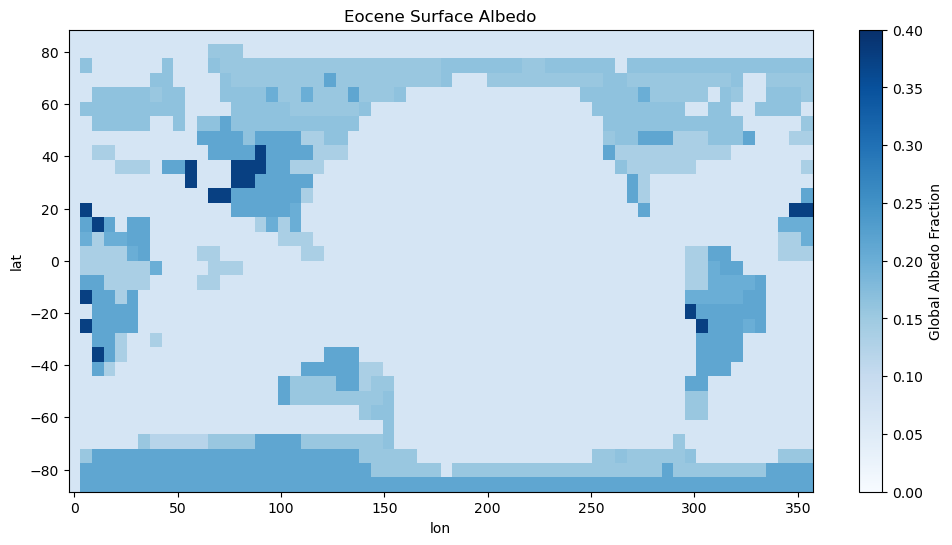

In [32]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

ds_lsm = xr.open_dataset('~/work/git/0172_cdo.nc')
lsm = ds_lsm['lsm']  

ds_bio_remapped = xr.open_dataset('biomes_cdo.nc')
biome_cdo = ds_bio_remapped['eocene_biome_hp']

# Albedo Dictionary (Values based on your provided list)
biome_to_albedo = {
    1: 0.135,  # Tropical forest
    2: 0.165,  # Warm Temperate forest
    3: 0.155,  # Temperate forest
    4: 0.12,   # Boreal forest (snow-free)
    5: 0.20,   # Savanna and dry woodland
    6: 0.215,  # Grassland and dry shrubland
    7: 0.375,  # Desert
    8: 0.25,   # Dry tundra
    9: 0.215,  # Tundra (snow-free)
    10: 0.725  # Land ice
}


biome = biome_cdo.reindex_like(lsm, method='nearest')

# Initialize the base map with OCEAN Albedo (0.07 is standard for open water)
# This ensures that if a pixel is ocean, it already has the correct value.

albedo_map = xr.full_like(lsm, 0.07, dtype=float)


for code, value in biome_to_albedo.items():
    # Condition: If biome is X, assign albedo Y
    albedo_map = xr.where(biome == code, value, albedo_map)

# Force ocean pixels (LSM < 0.5) to have water albedo (0.07)
# This fixes any potential inconsistencies where biomes might spill into the sea.

albedo_map = xr.where(lsm >= 0.5, albedo_map, 0.07)

ds_alb = albedo_map.to_dataset(name='albedo')

ds_alb['albedo'].attrs = {
    'code': 174,
    'long_name': 'Surface Background Albedo',
    'units': 'fraction',
    'standard_name': 'surface_albedo',
    'source': 'Herold Biomes + LSM Consistency',
    
}

ds_alb.to_netcdf('0174.nc')

plt.figure(figsize=(12, 6))
cmap=plt.cm.Blues

p = albedo_map.plot(
    cmap=cmap, 
    vmin=0.0, vmax=0.4,
    cbar_kwargs={'label': 'Global Albedo Fraction'}
)

plt.title('Eocene Surface Albedo')
plt.show()

The following file was then remapped on plasim grid with the previous CDO procedure (0174_remapped.nc) and then transformed to 14 monthly mean sra.

cdo setgrid,0129_remapped.nc 0174.nc 0174_remapped.nc

./nc2sra 0174_cdo.nc 0174_1m.sra 174

cat 0174_1m.sra 0174_1m.sra 0174_1m.sra 0174_1m.sra \
    0174_1m.sra 0174_1m.sra 0174_1m.sra 0174_1m.sra \
    0174_1m.sra 0174_1m.sra 0174_1m.sra 0174_1m.sra \
    0174_1m.sra 0174_1m.sra > N032_surf_0174.sra

The following is an example of how the global albedo map would look like with the values we picked for each vegetation classes applied to Herold et al. Eocene topography.

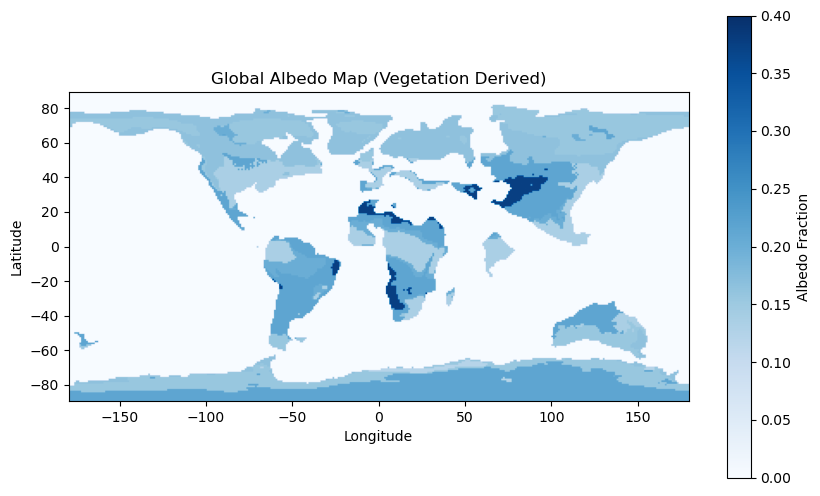

In [31]:

biome = ds_bio['eocene_biome_hp'] 
lat = biome['lat'].values
lon = biome['lon'].values


albedo = np.zeros_like(biome, dtype=np.float32)
for biome_class, albedo_value in biome_to_albedo.items():
    albedo[biome == biome_class] = albedo_value

plt.figure(figsize=(10, 6))

cmap = plt.cm.Blues

plt.imshow(albedo, origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()],
           cmap=cmap, vmin=0.0, vmax=0.4)
plt.colorbar(label='Albedo Fraction')
plt.title('Global Albedo Map (Vegetation Derived)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### SRA File Generation

The `.sra` files were created using the `makesra` tool, which ensures all missing values (`NaN`) are handled prior to processing. Depending on the variable type, one of two generation methods was used:

* **Constant Fields:** Created using `./makesra constant [codefile]`. This generates a single time-step field (used for static variables like topography or capacity).
* **Monthly Means:** Created using `./makesra -m 14 [codefile]`. This generates 14 time-steps (12 months + 2 header/footer steps) required for time-varying variables.
    > **Note:** Constant values were replicated 14 times using `cat` if a flat baseline was needed across all months.

### `0229.sra`, `0210.sra`, `0232.sra`, `169.sra`

* **`0229.sra` (Max Soil Water Capacity):** Constant field initialized to the global Plasim default mean value of **0.5 m**.
* **`0232.sra` (Glacier Fraction):** Constant field set to **0** everywhere, reflecting the ice-free nature of the Eocene (no "Land Ice" - Herold Class 10- biome). 
* **`0210.sra` (Climatological Sea Ice):** Monthly mean field set to **0** everywhere to satisfy dynamic sea ice setup requirements.
* **`0169.sra` (Sea Surface Temperature):** Monthly climatology initialized to a baseline of **291.15 K (18°C)**, replicated into 14 time-steps to cover the annual cycle.